In [1]:
# Load Seurat object and create pseudobulk for MOFA analysis
# Necessary cell annotations in the seurat object are: 'cluster_id' (giving the cell-type cluster annotations), 'sample_id' (unique identifier of a sample)

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/mofa_analysis//lib/R/library"


‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::betwee

In [3]:
source('MS2_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [4]:
### Load the parameters that are set via the configuration files

In [5]:
### Load configurations file
global_configs = read.csv('configurations/Data_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/Data_Configs.csv'”


In [6]:
head(global_configs,2)

,parameter,value
,<chr>,<chr>
1,data_path,/lustre/groups/epigenereg01/workspace/projects/jove/input_data/
2,result_path,/lustre/groups/epigenereg01/workspace/projects/jove/results/


In [7]:
data_path = global_configs$value[global_configs$parameter == 'data_path']

In [8]:
data_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/input_data/"

In [9]:
result_path = global_configs$value[global_configs$parameter == 'result_path']

In [10]:
result_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results/"

In [11]:
## Loading the file containing the name of the single-cell dataset

In [12]:
sc_configs = read.csv('configurations/01_Pre_Processing_SC_Data.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/01_Pre_Processing_SC_Data.csv'”


In [13]:
head(sc_configs,2)

,data_name,data_type
,<chr>,<chr>
1,Prepared_sc_Data,h5seurat


In [14]:
sc_configs = sc_configs[sc_configs$data_name != '',]

In [15]:
sc_dataset_names = unique(sc_configs$data_name)

In [16]:
sc_dataset_names

[1] "Prepared_sc_Data"

In [17]:
### Generate the result data directory if it does not exist yet
if(!file.exists(paste0(result_path, '01_results'))){
    dir.create(file.path(paste0(result_path, '01_results')))
    }

# Load Data 

## Load Seurat object

In [18]:
### Load single-cell datasets as h5seurat format; should contain the meta-columns: sample_id; cluster_id
### Raw Counts should be given in default assay

In [19]:
sc_data_list = list()

In [ ]:
###### Load the generated seurat objects
for(i in sc_dataset_names){
    source_text = paste( data_path, '/', i , '.h5seurat', sep = '')
    print(source_text)
    print(file.info(source_text)$mtime)
    rna_seurat_data = LoadH5Seurat(source_text, assays = "RNA", quietly = TRUE )
    
    sc_data_list[[i]] = rna_seurat_data
    }


[1] "/lustre/groups/epigenereg01/workspace/projects/jove/input_data//Prepared_sc_Data.h5seurat"
[1] "2023-12-08 10:27:41 CET"


Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA



## Data - Checks 

In [25]:
# Optional execute some checks to see whether raw counts will be used

In [26]:
#head(colSums(x = rna_seurat_data, slot = "counts") )  # raw count values from original matrix

In [27]:
#colnames(rna_seurat_data[[]]) # needs to contain cluster_id + sample_id

In [28]:
#dim(rna_seurat_data@assays$RNA@scale.data)

In [29]:
#DefaultAssay(rna_seurat_data)  

In [30]:
## Add dummy group_id (this is necessary for the aggregation function but will not be used in any other way)

In [31]:
sc_data_list = lapply(sc_data_list, function(x){
    x$group_id = 'dummy'
    return(x)
    })

In [32]:
head(sc_data_list[[1]]@meta.data,2)

,cluster_id,sample_id,group_id
,<chr>,<chr>,<chr>
AAACCCACATACAGGG-1-L1,B cell,m9.1,dummy
AAACCCACATGACTTG-1-L1,CD16 Mono,m9.1,dummy


# Data Processing

## Convert to SCE 

In [33]:
### Convert the seurat format to Single-Cell Experiment format (as this is the input required by the aggregation function)

In [34]:
sc_data_list = lapply(sc_data_list, function(x){
    as.SingleCellExperiment(x)
    })
    

In [35]:
sc_data_list[[1]]

class: SingleCellExperiment 
dim: 19221 148275 
metadata(0):
assays(2): counts logcounts
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(148275): AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 ...
  TTTGTTGGTGGACCAA-1-L14 TTTGTTGTCGAAGAAT-1-L14
colData names(4): cluster_id sample_id group_id ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

## Check amount of cells per sample and cluster 

In [36]:
### Check the amount of cells per sample and cluster to evaluate which cell-type clusters might have too low amount of cells per sample

In [37]:
### Amount of cells per cluster
lapply(sc_data_list, function(x){
    colSums(table(x$cluster_id,x$cluster_id ))
    })

$Prepared_sc_Data
             ASDC            B cell         CD14 Mono         CD16 Mono 
                8              9829             32727              4680 
          CD4 CTL         CD4 Naive CD4 Proliferating           CD4 TCM 
             2346              6495               108             45102 
          CD4 TEM         CD8 Naive CD8 Proliferating           CD8 TCM 
             6296              2612                13               525 
          CD8 TEM              cDC1              cDC2               dnT 
            10611                83              1314               130 
          Doublet             Eryth               gdT              HSPC 
               48                 6              1901               332 
              ILC              MAIT                NK  NK Proliferating 
              931              1177             15699               168 
    NK_CD56bright               pDC       Plasmablast          Platelet 
              874               745               703               450 
             Treg 
             2362

In [38]:
### Save the result as a dataframe for usage in the next script

In [39]:
cells_per_sample_cluster = lapply(sc_data_list, function(x){
    as.data.frame( t(table(x$cluster_id, x$sample_id)))
    })

In [40]:
### Rename columns

In [41]:
cells_per_sample_cluster = lapply(cells_per_sample_cluster, function(x){
    colnames(x) = c('sample_id', 'cluster_id', 'Freq')
    return(x)
    })

In [42]:
head(cells_per_sample_cluster[[1]])

,sample_id,cluster_id,Freq
,<fct>,<fct>,<int>
1,k10,ASDC,0
2,k11,ASDC,0
3,k12,ASDC,0
4,k13,ASDC,0
5,k14,ASDC,0
6,k15,ASDC,0


In [43]:
names(cells_per_sample_cluster)

[1] "Prepared_sc_Data"

In [44]:
result_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results/"

In [45]:
### Save
for(i in names(cells_per_sample_cluster)){
    write.csv(cells_per_sample_cluster[[i]], paste0(result_path, '/01_results/01_', i, '_Cell_Sample_Cluster_Distribution.csv'))
    }
    

In [46]:
### Visualize the result

In [47]:
## Categorize the amount of cells

In [48]:
cells_per_sample_cluster = lapply(cells_per_sample_cluster, function(x){
    colnames(x) =  c('Sample', 'Cluster_Cell_Type', 'amount_cells')
    x$amount_cells_cat[(x$amount_cells <= 3)  ] = '0-3'
    x$amount_cells_cat[(x$amount_cells <= 10)  & (x$amount_cells >3 )] = '3-10'
    x$amount_cells_cat[(x$amount_cells <= 20)  & (x$amount_cells >10 )] = '10-20'
    x$amount_cells_cat[(x$amount_cells <= 50)  & (x$amount_cells >20 )] = '20-50'
    x$amount_cells_cat[(x$amount_cells > 50)  ] = '> 50'
    return(x)
    })

In [49]:
head(cells_per_sample_cluster[[1]],2)

,Sample,Cluster_Cell_Type,amount_cells,amount_cells_cat
,<fct>,<fct>,<int>,<chr>
1,k10,ASDC,0,0-3
2,k11,ASDC,0,0-3


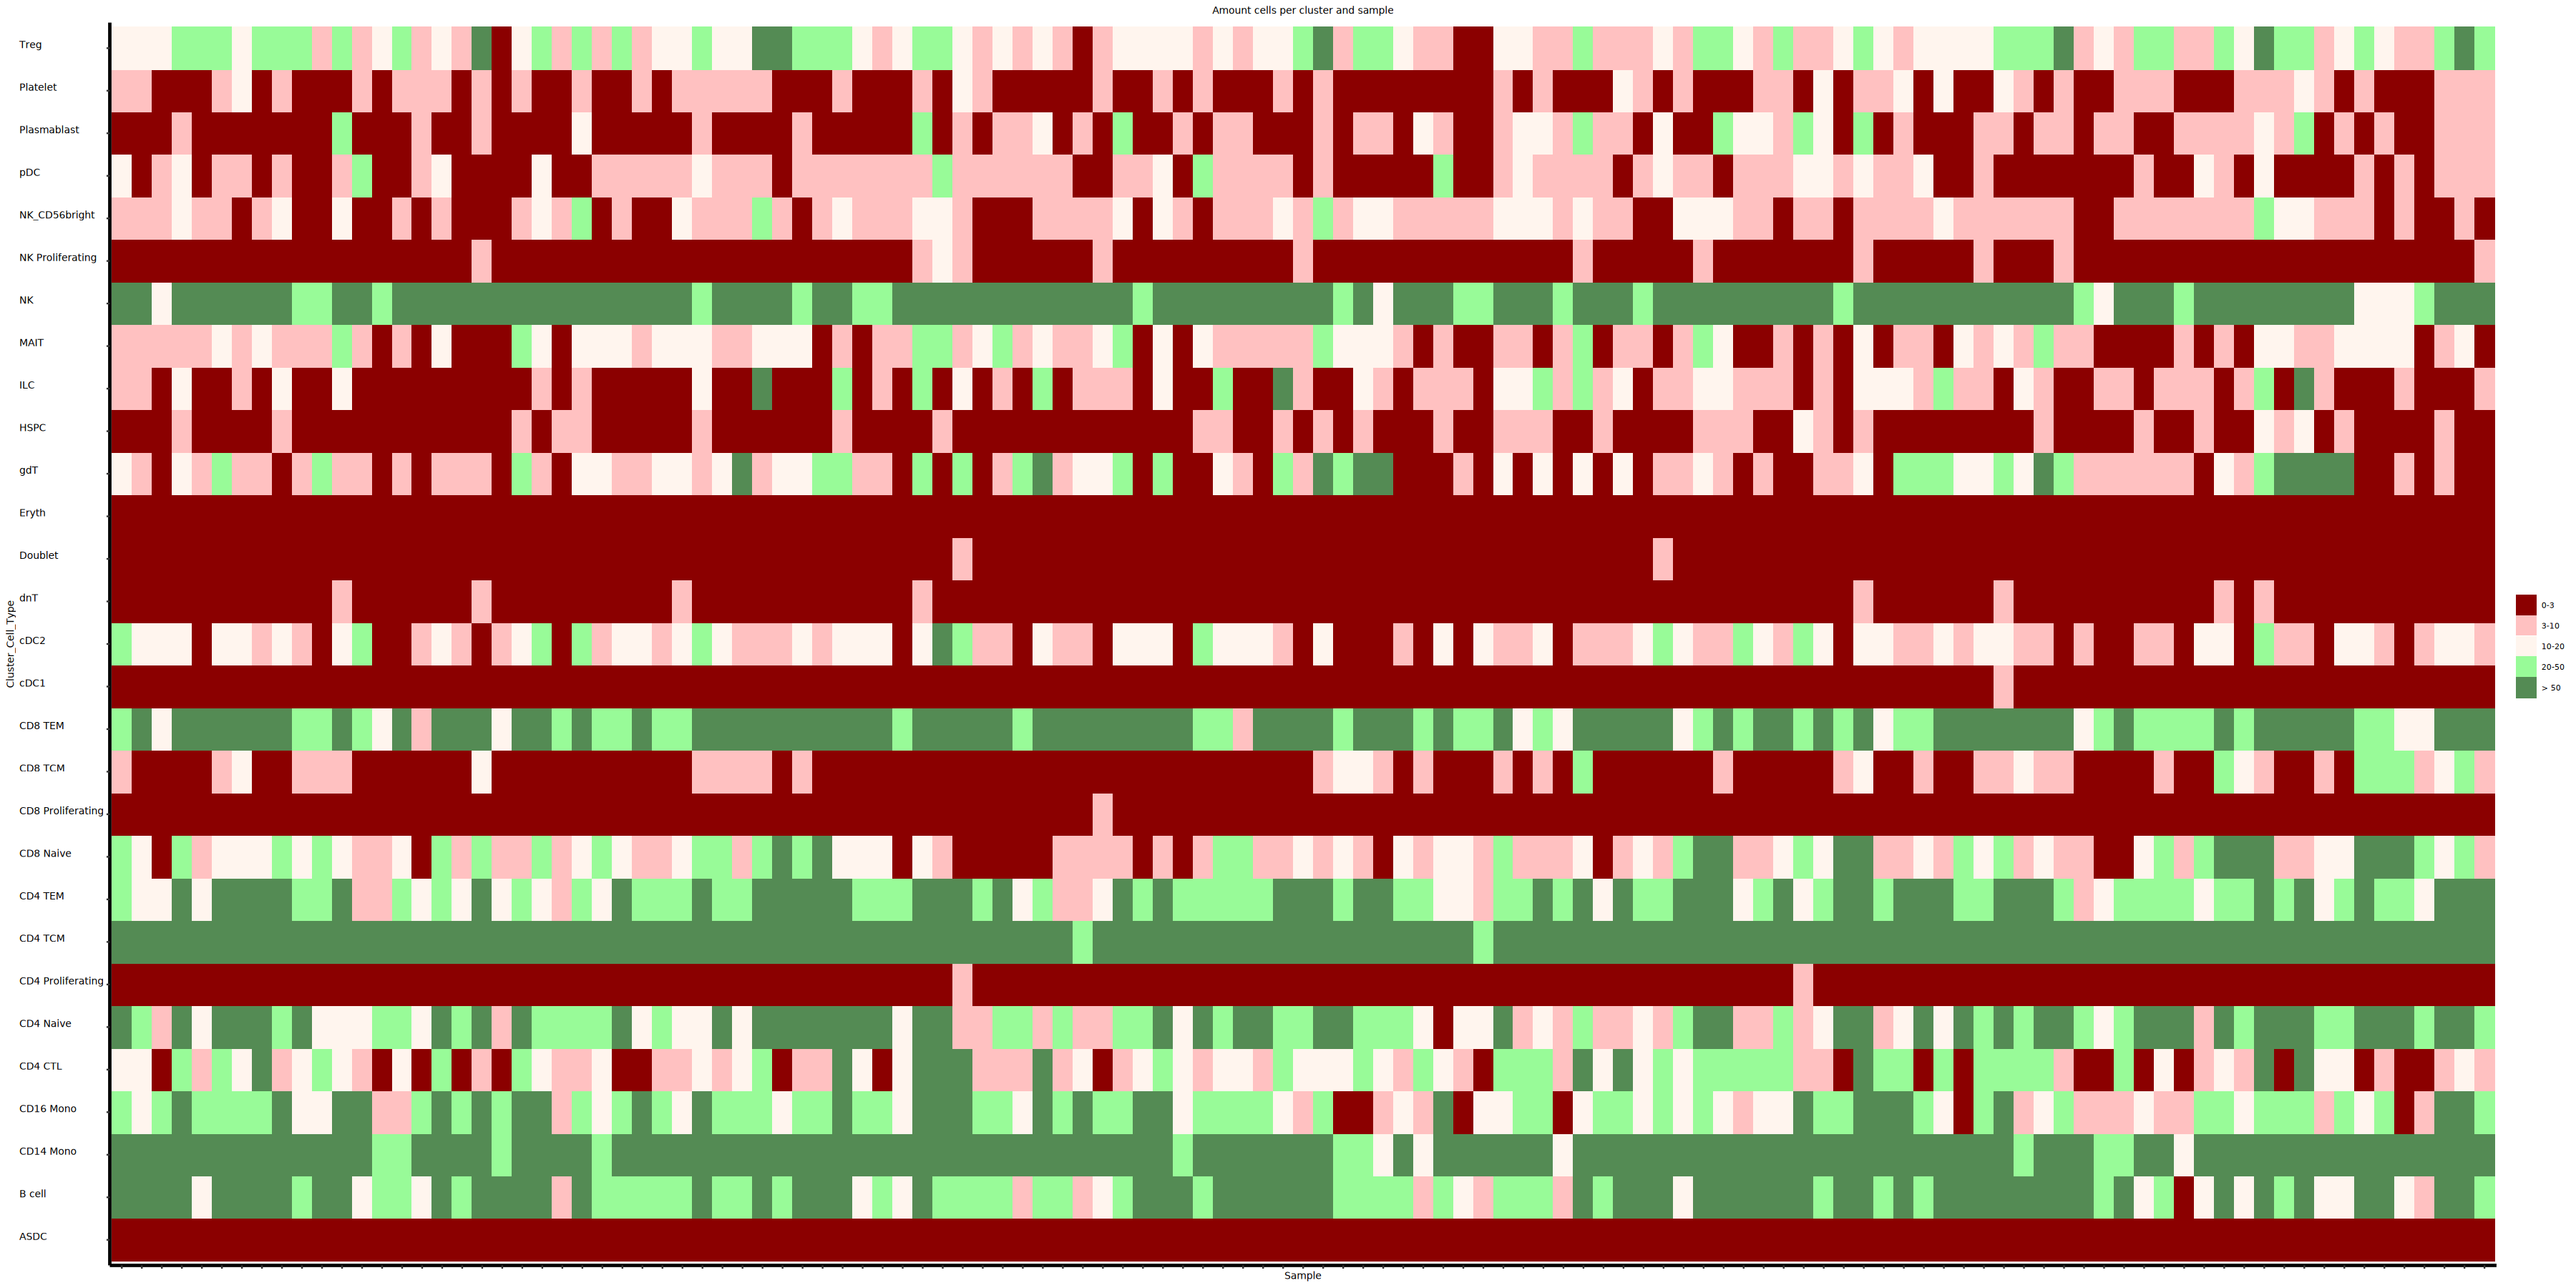

In [50]:
options(repr.plot.width=30, repr.plot.height=15)
g = lapply(cells_per_sample_cluster, function(x){
    ggplot(x, aes(Sample, Cluster_Cell_Type, fill= amount_cells_cat))  + geom_tile()   + ggtitle(label = "Amount cells per cluster and sample")+ #theme(axis.text.x=element_text(size=14, angle = 90), axis.text.y=element_text(size=14, angle = 0),axis.title=element_text(size=14,face="bold")) + 
    scale_fill_manual(name = "Amount cells", breaks=c( '0-3','3-10', 
                                 '10-20', '20-50', '> 50'), values =c("red4","rosybrown1",  "seashell", "palegreen", "palegreen4")) + plot_config + theme(axis.text.x = element_blank())
    })
# Visualize for first dataset
g[[1]]

In [51]:
names(g)

[1] "Prepared_sc_Data"

In [52]:
## Save figures for later inspection 

In [53]:
figure_name = "FIG01_Amount_of_Cells_per_Sample_and_Cell_Type"

In [54]:
# Sizes of the plot
width_par = 8
height_par = 5

In [55]:
pdf(paste0('figures/01_figures/', figure_name, i,  '.pdf'), width =width_par, height =height_par)
for(i in names(g)){
    print(g[[i]] )
    dev.off()
    }

## Calculate gene expression percentages per cluster for thresholding

In [56]:
### Calculate the percentage of cells having non-zero values for each gene per cluster
### will later be used to remove genes that are only expressed in a very low amount of cells

In [57]:
## Generate empty lists and data.frames to store the result in

In [58]:
gene_list = list()

In [59]:
gene_cell_expr = list()

In [60]:
gene_cell_expr_data = data.frame()

In [61]:
clusters = lapply(sc_data_list, function(x){
    unique(x$cluster_id)
    })

In [62]:
clusters[[1]]

[1] "B cell"            "CD16 Mono"         "CD4 TCM"          
 [4] "Plasmablast"       "CD8 TEM"           "CD4 Naive"        
 [7] "CD14 Mono"         "Treg"              "CD4 TEM"          
[10] "NK"                "CD8 Naive"         "cDC2"             
[13] "dnT"               "MAIT"              "HSPC"             
[16] "gdT"               "Platelet"          "CD8 TCM"          
[19] "NK_CD56bright"     "CD4 CTL"           "cDC1"             
[22] "pDC"               "CD4 Proliferating" "NK Proliferating" 
[25] "ILC"               "Doublet"           "CD8 Proliferating"
[28] "ASDC"              "Eryth"

In [63]:
### Calculate the gene expression percentages per cluster

In [64]:
gene_expr_data = lapply(sc_data_list, function(x){
    clusters = unique(x$cluster_id)
    for(i in clusters){
        # subset data on cluster
        rna_sce_subset= x[,x$cluster_id== i] # cluster
        amount_cells = dim(rna_sce_subset)[2]

        # Calculate percentage of cells expressing gene
        amount_cells_expressing_gene = rowSums(assay(rna_sce_subset) > 0 )
        perc_cells_expressing_gene = (amount_cells_expressing_gene/ amount_cells) * 100

        gene_cell_expr[[i]] = data.frame(perc_cells_expressing_gene = perc_cells_expressing_gene, total_amount_cells_expressing_gene = amount_cells_expressing_gene)
        
        # Format as data frame
        data = gene_cell_expr[[i]]
        data$gene = rownames(gene_cell_expr[[i]])
        data$cluster = i
        gene_cell_expr_data = rbind( gene_cell_expr_data, data)
        
        

        }
    return(gene_cell_expr_data)

})

    
    

In [65]:
head(gene_expr_data[[1]],2)

,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<dbl>,<int>,<chr>,<chr>
AL627309.1,0.23400142,23,AL627309.1,B cell
AL627309.4,0.06104385,6,AL627309.4,B cell


In [66]:
unique(gene_expr_data[[1]]$cluster)

[1] "B cell"            "CD16 Mono"         "CD4 TCM"          
 [4] "Plasmablast"       "CD8 TEM"           "CD4 Naive"        
 [7] "CD14 Mono"         "Treg"              "CD4 TEM"          
[10] "NK"                "CD8 Naive"         "cDC2"             
[13] "dnT"               "MAIT"              "HSPC"             
[16] "gdT"               "Platelet"          "CD8 TCM"          
[19] "NK_CD56bright"     "CD4 CTL"           "cDC1"             
[22] "pDC"               "CD4 Proliferating" "NK Proliferating" 
[25] "ILC"               "Doublet"           "CD8 Proliferating"
[28] "ASDC"              "Eryth"

In [67]:
### Save results for later filtering
for(i in names(gene_expr_data)){
    write.csv(gene_expr_data[[i]], paste0(result_path, '/01_results/01_', i, '_Gene_Expr_per_Cell_Type', '.csv'))
    }
    

## Aggregate to pseudobulk

In [68]:
### Add cluster and sample-id to use for aggregation

In [69]:
sc_data_list = lapply(sc_data_list, function(x){   

    #### Add cluster_id, sample_id and group_id columns
    x = prepSCE(x, 
        kid = 'cluster_id', # subpopulation assignments
        gid = 'group_id',  # group IDs (ctrl/stim)   # sample_id; using dummy sample id which corresponds to cluster columns
        sid = 'sample_id',   # sample IDs (ctrl/stim.1234)
        drop = FALSE)  # drop all other colData columns
    })


In [70]:
sc_data_list[[1]]

class: SingleCellExperiment 
dim: 19221 148275 
metadata(1): experiment_info
assays(2): counts logcounts
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(148275): AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 ...
  TTTGTTGGTGGACCAA-1-L14 TTTGTTGTCGAAGAAT-1-L14
colData names(4): cluster_id sample_id group_id ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [71]:
### Aggregate calculating the mean counts of each gene per cluster_id and sample_id

In [72]:
pb = lapply(sc_data_list, function(x){
        aggregateData(x,
        assay = "counts", fun = "mean",
        by = c("cluster_id", "sample_id"))
    })
# one sheet per subpopulation will be generated

In [73]:
pb[[1]]

class: SingleCellExperiment 
dim: 19221 119 
metadata(2): experiment_info agg_pars
assays(29): ASDC B cell ... Platelet Treg
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(119): k10 k11 ... m9.2 m9.3
colData names(2): group_id ident
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [74]:
### Save aggregated data

In [75]:
for(i in names(pb)){
    save(  pb , file = paste0(result_path, '/01_results/01_', i, 'Pseudobulk_.RDS'))
    }

## Convert to Table Format (CSV)

In [76]:
### Convert the pseudobulk aggregation to table format

In [77]:
sc_data = data.frame()

In [78]:
for(j in 1:length(pb)){
    dataset = names(pb)[j]
    
    for(i in names(assays(pb[[j]]))){
        data = assay(pb[[j]], i)
        
        data = as.data.frame(t(data))
        data$type = i
        
        data$dataset = dataset
        data$sample_id = rownames(data)
        data = melt(data, id.vars = c('sample_id', 'type', 'dataset'))
        
        sc_data = rbind(sc_data,data)
       
        
        }
    }
    

In [79]:
head(sc_data,2)

,sample_id,type,dataset,variable,value
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,k10,ASDC,Prepared_sc_Data,AL627309.1,0
2,k11,ASDC,Prepared_sc_Data,AL627309.1,0


In [80]:
write.csv( sc_data, paste0(result_path, '/01_results/01_Prepared_sc_DataPseudobulk_Table', '.csv'))